In [1]:
import re
from tqdm import tqdm_notebook
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

Using TensorFlow backend.


In [2]:
import pandas as pd
import spacy
import numpy as np

In [3]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
MAX_NB_WORDS = 50000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 60 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 50      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "Glove/glove.6B/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [5]:
# Read the train and test set
train = pd.read_csv('/Users/mac/Desktop/Thesis2/Glove_LSTM/preprocess_data/Train_final.csv')
test = pd.read_csv('/Users/mac/Desktop/Thesis2/Glove_LSTM/preprocess_data/Test_final.csv')
train.shape,test.shape

((10000, 2), (1000, 2))

In [6]:
train.head()

,label,text
0,0,-PRON- grow up b 1965 watch and love the Thund...
1,0,when -PRON- put this movie in -PRON- dvd playe...
2,0,why do people who do not know what a particula...
3,0,even though -PRON- have great interest in bibl...
4,1,-PRON- be a die hard Dads Army fan and nothing...


In [7]:
comments_train = train['text']
comments_test = test['text']
train_label = train['label']
test_label = test['label']

In [8]:
x_train = list(comments_train)
y_train = list(train_label)

In [9]:
print('Sample data:', x_train[1], y_train[1])

Sample data: when -PRON- put this movie in -PRON- dvd player and sit down with a coke and some chip -PRON- have some expectation -PRON- be hope that this movie would contain some of the strongpoint of the first movie awsome animation good flow story excellent voice cast funny comedy and a kickass soundtrack but to -PRON- disappointment not any of this be to be find in Atlantis Milo 's return have -PRON- read some review first -PRON- may not have be so let down the follow paragraph will be direct to those who have see the first movie and who enjoy -PRON- primarily for the point mentionedbr br when the first scene appear -PRON- in for a shock if -PRON- just pick Atlantis Milo 's return from the displaycase at -PRON- local videoshop or whatever and have the expectation -PRON- have the music feel as a bad imitation of the first movie and the voice cast have be replace by a not so fitting one with the exception of a few character like the voice of Sweet the actual drawing be not that bad bu

In [10]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(x_train)

In [11]:
sequences = tokenizer.texts_to_sequences(x_train)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 64290


In [12]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', train_label.shape)

Shape of data tensor: (10000, 60)
Shape of label tensor: (10000,)


In [13]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = train_label[indices]

In [14]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

In [15]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  3981
validation:  976


In [16]:
x_train.shape

(8000, 60)

In [17]:
print('Tokenized sentences: \n', data[10])
print('label: \n', labels[10])

Tokenized sentences: 
 [    2    47     5 11048    17     2  6436 11049     6     2 30821    18
  2724  1279  2013    13    13     2 16366     3    23    15    10    11
     3    44    80   332     6     5     2  2080    70    28     1     3
  2883   144   467    35     3    58   292   339    21     2   250    13
    13    90   160    43    19     1    72     1     3    64     4   241]
label: 
 1


In [18]:
embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: Glove/glove.6B/glove.6B.50d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [19]:
type(x_train)

numpy.ndarray

In [20]:
type(y_train)

pandas.core.series.Series

In [21]:
y_train.head()

8323    0
7030    1
4879    0
8837    1
6190    1
Name: label, dtype: int64

In [22]:
y_train.shape

(8000,)

In [23]:
y_train = y_train.values
y_val = y_val.values

In [24]:
type(y_val)


numpy.ndarray

In [25]:
type(y_train)

numpy.ndarray

In [26]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

In [27]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(1, activation="sigmoid")(x)

In [28]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
embeddings (Embedding)       (None, 60, 50)            3214550   
_________________________________________________________________
lstm_layer (LSTM)            (None, 60, 60)            26640     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

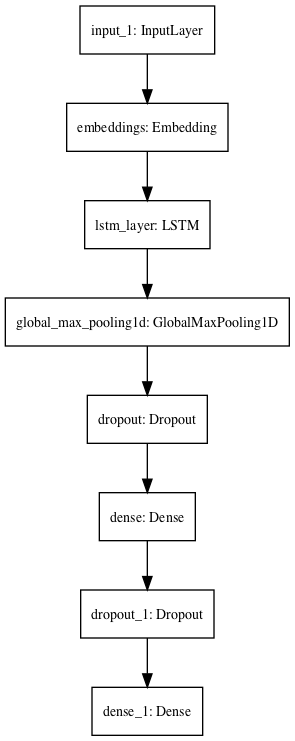

In [29]:
tf.keras.utils.plot_model(model)

In [30]:
type(y_train)

numpy.ndarray

In [31]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 2, batch_size=4, validation_data=(x_val, y_val))

Training progress:
Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 [==============================] - 251s 31ms/sample - loss: 0.5969 - accuracy: 0.6674 - val_loss: 0.5313 - val_accuracy: 0.7350
Epoch 2/2
8000/8000 [==============================] - 240s 30ms/sample - loss: 0.5038 - accuracy: 0.7610 - val_loss: 0.4958 - val_accuracy: 0.7550


In [34]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

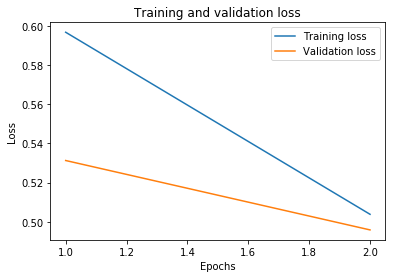

In [35]:

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

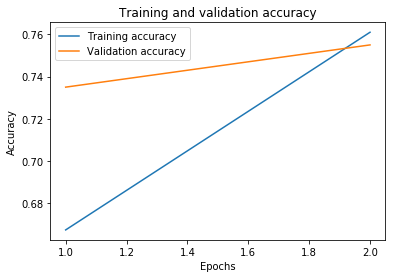

In [36]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();